In [111]:
import numpy as np
import tensorflow as tf
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]
#reshape the training data
trainData = trainData.reshape([trainData.shape[0], -1])
validData = validData.reshape([validData.shape[0], -1])
testData=testData.reshape([testData.shape[0], -1])

In [101]:
import tensorflow as tf

class Linear_Regression_Net:
    
    def build(self,num_of_features,learnning_rate,weight_decay_scale):
        
#         with self.graph.as_default():
            
        # Input data
        self.X = tf.placeholder(
            dtype=tf.float32,
            shape=[None,num_of_features])
        self.Y = tf.placeholder(
            dtype=tf.float32,
            shape=[None,1])
        X=self.X
        Y=self.Y

        #initializer
        weight_init = tf.contrib.layers.xavier_initializer(uniform=True)
        const_init = tf.constant_initializer(0.01)

        #weight bias
        W1 = tf.get_variable("W1",shape=[num_of_features,1],initializer=weight_init, dtype=tf.float32)
        b1  = tf.get_variable("b1",shape=[1,1],initializer=const_init, dtype=tf.float32)#broadcast
        #hidden layer
        y_ = tf.add(tf.matmul(X, W1), b1)

        #loss
        weight_decay = weight_decay_scale/2*tf.matmul(tf.transpose(W1),(W1))
        loss = tf.nn.l2_loss(y_-self.Y)/tf.cast(tf.shape(X)[0],tf.float32)+weight_decay
        self.loss = tf.squeeze(loss)
        self.predict = tf.cast(y_>0.5,tf.float32)
        self.optimizer = tf.train.GradientDescentOptimizer(learnning_rate)
        self.train_op = self.optimizer.minimize(loss)
        self.init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        self.accuracy = tf.reduce_sum(tf.cast(tf.equal(self.predict,self.Y),tf.float32))/tf.cast(tf.shape(self.Y)[0],tf.float32)


    def add_training_data(self,inputs,labels,batch_size):
        trainning_data = tf.constant(inputs, dtype=tf.float32)
        trainning_label = tf.constant(labels, dtype=tf.float32)
        #create a runner queue, shuffle every epoch
        x, y = tf.train.slice_input_producer([trainning_data, trainning_label], num_epochs=None,shuffle=True)
        #build mini-batch
        epoch = labels.shape[0]
        self.next_batch_op = tf.train.batch([x, y], batch_size=batch_size)
        
    def init(self,sess=None):
        sess = (sess or tf.get_default_session())
        sess.run(self.init_op)
        self.coord = tf.train.Coordinator()
        self.threads = tf.train.start_queue_runners(sess=sess, coord=self.coord)
        return sess
    
    def get_loss(self,inputs,labels,sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.loss, {self.X: inputs,self.Y: labels})
    
    def update(self,sess=None):
        sess = sess or tf.get_default_session()
        input_batch,label_batch = sess.run(self.next_batch_op)
        _,loss=sess.run([self.train_op,self.loss], {self.X: input_batch,self.Y: label_batch})
        return loss
    
    def get_prediction(self, data, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.predict, {self.X: data})
    
    
    def get_accuracy(self, inputs,labels, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.accuracy, {self.X: inputs,self.Y: labels})
        
    
    def train(self,trainData_rs, trainTarget, learnning_rate, weight_decay_scale, batch_size=500, steps=20000,sess=None):
        sess = sess or tf.get_default_session()
        epoch_size = trainData_rs.shape[0]
        
        summary=[]
        
        self.add_training_data(trainData_rs,trainTarget,batch_size)
        self.build(trainData_rs.shape[1],learnning_rate,weight_decay_scale)
        
        self.init()
        loss_val=0
        for step in range(steps):
            loss_val = self.update()
            if((step*batch_size)%epoch_size==0):
                summary.append(loss_val)
                    #print(loss_val)
        self.coord.request_stop()
        self.coord.join(self.threads)
        self.training_loss=loss_val
        return summary

In [104]:
# Q1
BATCH_SIZE = 500
LEARNING_RATES = (0.005, 0.001, 0.0001)
weight_decay_scale = 0


summarys=[]

net = Linear_Regression_Net()

for LEARNING_RATE in LEARNING_RATES:
    tf.reset_default_graph()
    sess = tf.Session()
    with sess.as_default():
        summary= net.train(trainData, trainTarget, LEARNING_RATE, weight_decay_scale, BATCH_SIZE, 400)
        summarys.append(summary)
    sess.close()

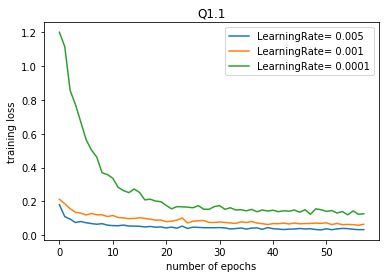

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
for i,summary in enumerate(summarys):
    plt.plot(summary, label='LearningRate= '+str(LEARNING_RATES[i]))
    plt.ylabel("training loss")
    plt.xlabel("number of epochs")
    plt.title("Q1.1")
plt.legend()

### From the graph, the best learning rate is 0.005, as the loss converges faster and the final loss is smaller with learning_rate=0.005

In [93]:
#Q2
import time
B = [500,1500,3500]
learning_rate =  0.005
weight_decay_scale = 0
losses=[]
times=[]
summarys=[]
for batch_size in B:
    tf.reset_default_graph()
    sess = tf.Session()
    start = time.time()
    with sess.as_default():
        summary=net.train(trainData, trainTarget, learning_rate, weight_decay_scale, batch_size, steps=400)
        summarys.append(summary)
        losses.append(net.training_loss)
        
    sess.close()
    end = time.time()
    times.append((end - start))
    
# Report the final training MSE for each mini-batch value 
# What is the best mini-batch size in terms of training time? 
# Comment on your observation.

10.21706485748291,0.03212197
26.912514448165894,0.03010679
68.18716049194336,0.034357596


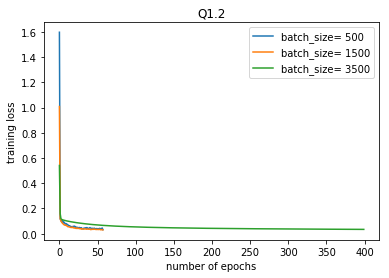

In [94]:
for time,loss in zip(times,losses):
    print(str(time)+","+str(loss))
    
plt.figure()
for i,summary in enumerate(summarys):
    plt.plot(summary, label='batch_size= '+str(B[i]))
    plt.ylabel("training loss")
    plt.xlabel("number of epochs")
    plt.title("Q1.2")
plt.legend()

## Batch_size 5 is the best choice in terms of training time. They all converge to the similar loss point, but the training with batch_size=500 take the least amount of time to finish the same amount of iterations.

In [112]:
#Q3
weight_decay_ratios = [0,0.001,0.1,1]
batch_size = 500

accuracys=[]
for weight_decay_scale in weight_decay_ratios:
    tf.reset_default_graph()
    sess = tf.Session()
    with sess.as_default():
        summary=net.train(validData, validTarget, learning_rate, weight_decay_scale, batch_size, steps=1000)
        validation_accuracy = net.get_accuracy(validData,validTarget)
        test_accuracy = net.get_accuracy(testData,testTarget)
        accuracys.append((validation_accuracy,test_accuracy))

In [113]:
for accuracy in accuracys:
    print(accuracy)

(1.0, 0.92413795)
(1.0, 0.94482756)
(1.0, 0.93793106)
(0.99, 0.94482756)


In [187]:
#Q4
class Normal_Equation_Method:
    def optimal_weight(self,inputs,labels,weight_decay):
        X0 = tf.ones([inputs.shape[0],1])
        X = tf.concat(axis=1, values=[tf.constant(inputs,tf.float32),X0])
        Y = tf.constant(labels,tf.float32)
        W_ = tf.matmul(tf.transpose(X),X) + weight_decay*tf.constant(np.identity(X.get_shape()[1]),tf.float32) 
        W_ = tf.matmul(tf.matrix_inverse(W_),tf.transpose(X))
        W_ = tf.matmul(W_,Y)
        return W_

    def build(self,inputs,labels,weight_decay):
        
        self.X_input = tf.placeholder(tf.float32,[None,inputs.shape[1]])
        X0 = tf.ones([tf.shape(self.X_input)[0],1])
        self.X = tf.concat(axis=1, values=[self.X_input,X0])
        self.Y = tf.placeholder(tf.float32,[None,1])
        self.W_= self.optimal_weight(inputs,labels,weight_decay)
        self.Y_ = tf.matmul(self.X, self.W_)
        self.predict = tf.cast(self.Y_>0.5,tf.float32)
        self.accuracy = tf.reduce_sum(tf.cast(tf.equal(self.predict,self.Y),tf.float32))/tf.cast(tf.shape(self.Y)[0],tf.float32)
        
    
    def get_accuracy(self,inputs,labels,sess=None):
        sess=sess or tf.get_default_session()
        accu = sess.run(self.accuracy,{self.X_input:inputs,self.Y:labels})
        return accu
        

In [198]:

normal_eqn=Normal_Equation_Method()
tf.reset_default_graph()
sess=tf.Session()
with sess.as_default():
    normal_eqn.build(trainData,trainTarget,0)
    print(str(normal_eqn.get_accuracy(trainData,trainTarget)))

0.99314284


In [104]:
def logistic_train(trainData_rs, trainTarget, learnning_rate, weight_decay_scale, batch_size=500, steps=20000):
    trainning_data = tf.constant(trainData_rs, dtype=tf.float32)
    trainning_label = tf.constant(trainTarget, dtype=tf.float32)
    # create a runner queue
    x, y = tf.train.slice_input_producer([trainning_data, trainning_label], num_epochs=None)
    # build mini-batch
    X, Y = tf.train.batch([x, y], batch_size=batch_size)
    
    # predict and loss
    #initializer
    weight_init = tf.contrib.layers.xavier_initializer(uniform=True)
    const_init = tf.constant_initializer(0.01)
    
    #weight bias
    W1 = tf.get_variable("W1",shape=[X.shape[1],1],initializer=weight_init, dtype=tf.float32)
    b1  = tf.get_variable("b1",shape=[1,1],initializer=const_init, dtype=tf.float32)#broadcast
    #hidden layer
    logits = tf.add(tf.matmul(X, W1), b1)
    cross_entropy_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = Y))/batch_size
    predict = tf.cast(tf.sigmoid(logits) > 0.5, tf.float32)
    #loss
    weight_decay = weight_decay_scale/2*tf.matmul(tf.transpose(W1),(W1))
    loss = cross_entropy_loss+weight_decay
    loss = tf.squeeze(loss)
    classification_accuracy = tf.reduce_sum(tf.cast(tf.equal(Y,predict), tf.float32))/batch_size
    
    optimizer = tf.train.GradientDescentOptimizer(learnning_rate)
    train_op = optimizer.minimize(loss)
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    
    sess = tf.Session()
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    epoch_size = trainTarget.shape[0]
    print("epoch_size", epoch_size)
    summary=[]
    best_loss_val, best_accu = 1.0, 0;
    for step in range(steps):
        _, loss_val, accu = sess.run([train_op, loss, classification_accuracy])
        best_loss_val = min(best_loss_val, loss_val)
        best_accu = max(best_accu, accu)
        if((step*batch_size)%epoch_size==0):
            summary.append((best_loss_val, best_accu))
            print(step, best_loss_val, best_accu)
    return summary

In [105]:
BATCH_SIZE = 500
LEARNING_RATES = (0.005, 0.001, 0.0001)
weight_decay_scale = 0.01
tf.reset_default_graph()

summarys=[]
trainData_rs = trainData.reshape([trainData.shape[0], -1])
for LEARNING_RATE in LEARNING_RATES:
    tf.reset_default_graph()
    summary=logistic_train(trainData_rs, trainTarget, LEARNING_RATE, weight_decay_scale, BATCH_SIZE, 400)
    summarys.append(summary)

epoch_size 3500
0 0.983558 0.182
7 0.671673 0.608
14 0.506233 0.838
21 0.411738 0.9
28 0.349002 0.924
35 0.304904 0.936
42 0.27135 0.952
49 0.259996 0.958
56 0.231993 0.962
63 0.219808 0.966
70 0.207655 0.966
77 0.195386 0.972
84 0.189166 0.972
91 0.181052 0.972
98 0.170462 0.976
105 0.170462 0.976
112 0.155332 0.976
119 0.155332 0.978
126 0.15278 0.98
133 0.15278 0.98
140 0.144429 0.98
147 0.134911 0.98
154 0.134911 0.98
161 0.134911 0.98
168 0.134911 0.98
175 0.134911 0.98
182 0.129931 0.98
189 0.121651 0.98
196 0.121651 0.98
203 0.121651 0.982
210 0.121106 0.982
217 0.120178 0.982
224 0.120178 0.982
231 0.114642 0.982
238 0.114642 0.988
245 0.110257 0.988
252 0.110257 0.988
259 0.110257 0.988
266 0.103677 0.988
273 0.103677 0.988
280 0.103677 0.988
287 0.103677 0.988
294 0.103677 0.988
301 0.103677 0.988
308 0.103677 0.988
315 0.103677 0.988
322 0.103677 0.988
329 0.103677 0.988
336 0.0969269 0.988
343 0.0969269 0.988
350 0.0969269 0.988
357 0.0966007 0.99
364 0.0909061 0.99
371 0.0

KeyboardInterrupt: 

Text(0,0.5,'Value')

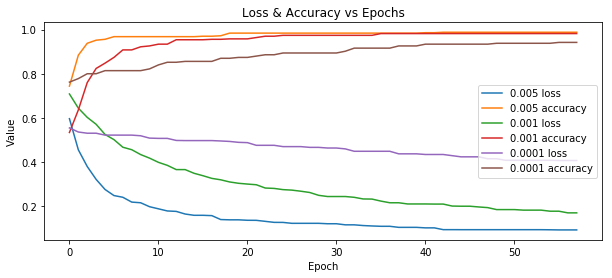

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
for i,summary in enumerate(summarys):
    s = np.array(summary)
    plt.plot(s[:,0], label=str(LEARNING_RATES[i])+" loss")
    plt.plot(s[:,1], label=str(LEARNING_RATES[i])+" accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")

The best learning rate is 0.005 from the graph since it has the fastest decay speed and best final error rate and classification accuracy.

In [107]:
BATCH_SIZE = 500
BEST_LEARNING_RATE = 0.005
weight_decay_scale = 0.01
tf.reset_default_graph()
summarys=[]
trainData_rs = trainData.reshape([trainData.shape[0], -1]) # flattern
validData_rs = validData.reshape([validData.shape[0], -1])
testData_rs = testData.reshape([testData.shape[0], -1])
summary_train=logistic_train(trainData_rs, trainTarget, BEST_LEARNING_RATE, weight_decay_scale, BATCH_SIZE, 400)
tf.reset_default_graph()
summary_valid=logistic_train(validData_rs, validTarget, BEST_LEARNING_RATE, weight_decay_scale, BATCH_SIZE, 400)
tf.reset_default_graph()
summary_test=logistic_train(testData_rs, testTarget, BEST_LEARNING_RATE, weight_decay_scale, BATCH_SIZE, 400)

epoch_size 3500
0 1.0 0.432
7 0.659791 0.63
14 0.491392 0.828
21 0.406853 0.896
28 0.349332 0.928
35 0.307189 0.942
42 0.276575 0.97
49 0.252119 0.97
56 0.235738 0.97
63 0.212538 0.97
70 0.202463 0.972
77 0.201173 0.972
84 0.178842 0.972
91 0.178842 0.974
98 0.171743 0.976
105 0.171743 0.976
112 0.15738 0.976
119 0.15738 0.976
126 0.151114 0.976
133 0.150745 0.982
140 0.141349 0.982
147 0.138836 0.982
154 0.127579 0.982
161 0.127579 0.982
168 0.127579 0.982
175 0.127579 0.986
182 0.124142 0.986
189 0.124142 0.986
196 0.124142 0.986
203 0.124142 0.986
210 0.117015 0.986
217 0.117015 0.986
224 0.117015 0.986
231 0.0998423 0.986
238 0.0998423 0.986
245 0.0998423 0.986
252 0.0998423 0.986
259 0.0998423 0.986
266 0.0998423 0.986
273 0.0998423 0.986
280 0.0998423 0.986
287 0.0968166 0.986
294 0.0968166 0.986
301 0.0968166 0.986
308 0.0968166 0.986
315 0.0968166 0.986
322 0.0968166 0.986
329 0.0968166 0.986
336 0.092407 0.988
343 0.092407 0.988
350 0.092407 0.988
357 0.092407 0.988
364 0.0924

399 0.0845667 0.99
epoch_size 145
0 0.932416 0.206
29 0.30947 0.948
58 0.209783 0.978
87 0.168109 0.978
116 0.144421 0.988
145 0.128847 0.99
174 0.118865 0.99
203 0.110877 0.99
232 0.103482 0.99
261 0.0991975 0.99
290 0.0951084 0.99
319 0.0905634 0.99
348 0.087519 0.99
377 0.0851179 0.99


Text(0,0.5,'Value')

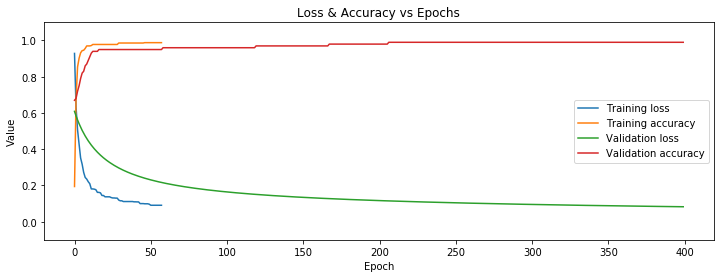

In [96]:
plt.figure(figsize=(12,4))
types = ['Training', 'Validation']
for i,summary in enumerate((summary_train, summary_valid)):
    s = np.array(summary)
    plt.plot(s[:,0], label=types[i]+" loss")
    plt.plot(s[:,1], label=types[i]+" accuracy")
plt.legend()
plt.ylim(-0.1,1.1)
plt.title("Loss & Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")

In [108]:
summary_test[-1]

(0.085117914, 0.99000001)

The best classification accuracy for test data is 99.00% for logistic regression model

In [110]:
with np.load("notMNIST.npz") as data:
    Data, Target = data ["images"], data["labels"]
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data = Data[randIndx]/255.
    Target = Target[randIndx]
    trainData, trainTarget = Data[:15000], Target[:15000]
    validData, validTarget = Data[15000:16000], Target[15000:16000]
    testData, testTarget = Data[16000:], Target[16000:]

In [161]:
def multi_class_logistic_train(trainData_rs, trainTarget, \
                               learnning_rate, weight_decay_scale, batch_size=500, steps=20000):
    trainData_rs = np.insert(trainData_rs, 0, 1, axis=1) # insert 1 for w0 into X
    trainning_data = tf.constant(trainData_rs, dtype=tf.float32)
    trainning_label = tf.one_hot(tf.constant(trainTarget, dtype=tf.int32), 10)
    num_classes = 10#tf.shape(trainning_label)[1]
    # create a runner queue
    x, y = tf.train.slice_input_producer([trainning_data, trainning_label], num_epochs=None)
    # build mini-batch
    X, Y = tf.train.batch([x, y], batch_size=batch_size)
    # predict and loss
    #initializer
    weight_init = tf.contrib.layers.xavier_initializer(uniform=True)
    const_init = tf.constant_initializer(0.01)
    
    #weight bias
    W1 = tf.get_variable("W1",shape=[X.shape[1],num_classes],initializer=weight_init, dtype=tf.float32)
    #hidden layer
    logits = tf.matmul(X, W1)
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = Y))
    predict = tf.argmax(tf.nn.softmax(logits), 1)
    #loss
    weight_decay = weight_decay_scale/2 * tf.norm(W1)**2
    loss = cross_entropy_loss+weight_decay
    loss = tf.squeeze(loss)
    classification_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1),predict), tf.float32))
    
    optimizer = tf.train.GradientDescentOptimizer(learnning_rate)
    train_op = optimizer.minimize(loss)
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    
    sess = tf.Session()
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    epoch_size = trainTarget.shape[0]
    print("epoch_size", epoch_size)
    summary=[]
    best_loss_val, best_accu = 2**32, 0;
    for step in range(steps):
        _, loss_val, accu = sess.run([train_op, loss, classification_accuracy])
        best_loss_val = min(best_loss_val, loss_val)
        best_accu = max(best_accu, accu)
        if((step*batch_size)%epoch_size==0):
            summary.append((best_loss_val, best_accu))
            print(step, best_loss_val,best_accu)
    return summary

In [162]:
BATCH_SIZE = 500
BEST_LEARNING_RATE = 0.005
weight_decay_scale = 0.01
tf.reset_default_graph()
summarys=[]
trainData_rs = trainData.reshape([trainData.shape[0], -1]) # flattern
validData_rs = validData.reshape([validData.shape[0], -1])
testData_rs = testData.reshape([testData.shape[0], -1])
summary_train=multi_class_logistic_train(trainData_rs, trainTarget, BEST_LEARNING_RATE, \
                                         weight_decay_scale, BATCH_SIZE, 400)
tf.reset_default_graph()
summary_valid=multi_class_logistic_train(validData_rs, validTarget, BEST_LEARNING_RATE, weight_decay_scale, BATCH_SIZE, 400)
tf.reset_default_graph()
summary_test=multi_class_logistic_train(testData_rs, testTarget, BEST_LEARNING_RATE, weight_decay_scale, BATCH_SIZE, 400)

epoch_size 15000
0 2.50249 0.118
30 2.02683 0.366
60 1.6905 0.6
90 1.53262 0.678
120 1.35363 0.738
150 1.24978 0.78
180 1.15312 0.798
210 1.0917 0.818
240 1.00386 0.844
270 0.954233 0.844
300 0.885467 0.862
330 0.885467 0.862
360 0.867512 0.862
390 0.836813 0.868
epoch_size 1000
0 2.70478 0.152
2 2.59294 0.152
4 2.56063 0.152
6 2.48503 0.152
8 2.43027 0.152
10 2.40347 0.152
12 2.33469 0.154
14 2.31151 0.17
16 2.28407 0.186
18 2.25169 0.186
20 2.21519 0.218
22 2.17266 0.232
24 2.14747 0.246
26 2.11182 0.278
28 2.11182 0.292
30 2.08066 0.306
32 2.03266 0.346
34 2.0324 0.38
36 1.97595 0.388
38 1.97595 0.388
40 1.95942 0.412
42 1.94221 0.412
44 1.90208 0.458
46 1.90208 0.458
48 1.87658 0.46
50 1.86446 0.468
52 1.82845 0.502
54 1.82845 0.518
56 1.8 0.522
58 1.75562 0.544
60 1.74873 0.55
62 1.71338 0.566
64 1.69657 0.582
66 1.69005 0.596
68 1.69005 0.596
70 1.6677 0.6
72 1.6677 0.6
74 1.64528 0.642
76 1.62877 0.642
78 1.62877 0.642
80 1.58848 0.644
82 1.58848 0.644
84 1.58795 0.65
86 1.55896